In [19]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [20]:
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import (PiecewisePolynomial, 
                         InverseKinematics, 
                         Sphere, 
                         Rgba, 
                         RigidTransform, 
                         RotationMatrix, 
                         Solve,
                         MathematicalProgram,
                         RollPitchYaw,
                         Cylinder,
                         VPolytope,
                         Role)
import time
import pydrake

In [21]:
from environments import get_environment_builder

plant_builder = get_environment_builder('2DOFFLIPPER')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)

INFO:drake:Meldis is listening for LCM messages at udpm://239.255.76.67:7667?ttl=0
INFO:drake:Meshcat listening for connections at http://localhost:7002


http://localhost:7002


In [22]:
inspector = scene_graph.model_inspector()
b = plant.GetBodyFrameIdIfExists(plant.GetBodyByName("roi_box", plant.GetModelInstanceByName("roi_box")).index(), )
ids = inspector.GetGeometries(b, Role.kIllustration)
vp = [VPolytope(scene_graph.get_query_output_port().Eval(scene_graph_context), id) for id in ids]
roi = HPolyhedron(vp[0])

In [23]:
from visibility_utils import (sample_in_union_of_polytopes, 
                              get_AABB_cvxhull,
                              )
from visualization_utils import plot_points
tmin, tmax, aabb = get_AABB_cvxhull([roi])
# pts = sample_in_union_of_polytopes(100, [roi], [tmin, tmax])
# pts[:,0] = 0
# plot_points(meshcat, pts, 'roitarg', size = 0.01)

In [24]:

_offset_meshcat_2 = np.array([-1,-5, 1.5])
def show_pose(qvis, plant, plant_context, diagram, diagram_context, endeff_frame, show_body_frame = None):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    transl = tf.translation()+tf.rotation()@np.array([0,0.0,0.05])
    meshcat.SetObject(f"/drake/q",
                                   Sphere(0.1),
                                   Rgba(0,1,0,1))
    p = np.zeros(3)
    p[1] = qvis[0]
    p[2] = qvis[1]
    meshcat.SetTransform(f"/drake/q",RigidTransform(p+_offset_meshcat_2))
    
    
    if show_body_frame is not None:
        show_body_frame(RigidTransform(tf.rotation(), transl))

def show_ik_target(pose, meshcat, name):
    h = 0.2
    if 'targ' in name:
        colors = [Rgba(1,0.5,0, 0.5), Rgba(0.5,1,0, 0.5), Rgba(0.0,0.5,1, 0.5)]
    else:
        colors = [Rgba(1,0,0, 1), Rgba(0.,1,0, 1), Rgba(0.0,0.0,1, 1)]

    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([h/2, 0,0])
    meshcat.SetObject(f"/drake/ik_target{name}/triad1",
                                   Cylinder(0.01,0.2),
                                   colors[0])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad1",RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,h/2,0])

    meshcat.SetObject(f"/drake/ik_target{name}/triad2",
                                   Cylinder(0.01,0.2),
                                   colors[1])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad2",RigidTransform(rot, pos))
    pos= pose.translation().copy()
    rot = pose.rotation()
    pos = pos + rot@np.array([0,0,h/2])
    meshcat.SetObject(f"/drake/ik_target{name}/triad3",
                                   Cylinder(0.01,0.2),
                                   colors[2])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad3",RigidTransform(rot, pos))
show_body_frame = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_acutal', 
                          )
showres = partial(show_pose, 
                  plant = plant, 
                  plant_context = plant_context, 
                  diagram = diagram, 
                  diagram_context = diagram_context,
                  endeff_frame = 'iiwa_twoDOF_link_7',
                  show_body_frame=show_body_frame)

In [25]:
q_meshcat = np.zeros(plant.num_positions())

sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

def handle_slider_change(change, idx):
    q_meshcat[idx] = change['new']
    showres(q_meshcat)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

In [26]:
#ik sliders 
from task_space_seeding_utils import solve_ik_problem, task_space_sampler_mp

show_ik_targets = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_targ', 
                          )

ik_solver = partial(solve_ik_problem, 
                    plant_ik = plant,
                    plant_context_ik = plant_context,
                    frames = [plant.GetFrameByName('iiwa_twoDOF_link_7')],
                    offsets = [np.array([0,0.0,0.05])],
                    collision_free=True,
                    track_orientation=False)
sliders_ik = []
pos_min = np.array([-1,-1])
pos_max = np.array([2.0,2])
names = ['y', 'z']
q0 = np.zeros(2)#np.array([ 0.23294, -0.2944 , -0.36706, -1.5944 , -0.16706,  0.     ,
       # 1.64567])
_ik_positions = np.zeros(2)

for i in range(2):
    sliders_ik.append(widgets.FloatSlider(min=pos_min[i], 
                                       max=pos_max[i], 
                                       value=0.5*(pos_max[i]-pos_min[i])+pos_min[i], 
                                       description=names[i]))
q_ik = np.zeros(plant.num_positions())
def handle_slider_change_ik(change, idx):
    _ik_positions[idx] = change['new']
    rot = RotationMatrix()
    pos = np.zeros(3)
    pos[1] = _ik_positions[0]
    pos[2] = _ik_positions[1]
    tf = RigidTransform(rot, pos)
    show_ik_targets(tf)
    res = ik_solver([tf], q0)
    q_ik[:] = res
    if res is not None:
        showres(res)

idx = 0
for slider in sliders_ik:
    slider.observe(partial(handle_slider_change_ik, idx = idx), names='value')
    idx+=1

for slider in sliders_ik:
    display(slider)

FloatSlider(value=0.5, description='y', max=2.0, min=-1.0)

FloatSlider(value=0.5, description='z', max=2.0, min=-1.0)

In [27]:
#sample in roi using IK
starting_confs = [np.array([1.5,1.0]),
                  np.array([-0.3,-1.0])]
 
ts_samplers = []
for q0 in starting_confs:    
    plant.SetPositions(plant_context, q0)
    plant.ForcedPublish(plant_context)
    showres(q0)
    t0 = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("iiwa_twoDOF_link_7")).translation()  
    sample_handle_ts = partial(task_space_sampler_mp,
                            q0 = q0,
                            t0 = t0,
                            plant_builder = plant_builder,
                            frame_names = ['iiwa_twoDOF_link_7'],
                            offsets = [np.array([0,0.0,0.05])],
                            cvx_hulls_of_ROI = [roi],
                            ts_min = tmin,
                            ts_max = tmax,
                            collision_free = True,
                            track_orientation = False,
                            
                            )
    ts_samplers.append(sample_handle_ts)


In [28]:
q_obj = []
t_obj = []
Npts = 100
for sh in ts_samplers:
    q, t, _, res = sh(Npts,[])
    q_obj +=[q]
    t_obj +=[t]

q_obj = np.concatenate(tuple(q_obj), axis=0)
t_obj = np.concatenate(tuple(t_obj), axis=0)

for i,t in enumerate([t_obj]):
    plot_points(meshcat, t, f"iksol{i}", size = 0.01)

100%|██████████| 5/5 [00:00<00:00, 230.46it/s]

100%|██████████| 5/5 [00:00<00:00, 147.32it/s]

100%|██████████| 5/5 [00:00<00:00, 121.61it/s]

100%|██████████| 5/5 [00:00<00:00, 135.18it/s]

100%|██████████| 5/5 [00:00<00:00, 89.84it/s]]

100%|██████████| 5/5 [00:00<00:00, 90.79it/s]]

100%|██████████| 5/5 [00:00<00:00, 105.48it/s]

100%|██████████| 5/5 [00:00<00:00, 128.08it/s]

100%|██████████| 5/5 [00:00<00:00, 131.65it/s]

100%|██████████| 5/5 [00:00<00:00, 38.79it/s]


In [29]:
import pickle, os, mcubes
from pydrake.all import SurfaceTriangle, TriangleSurfaceMesh
from visibility_utils import get_col_func
q_min = np.concatenate((np.array([-0]),plant.GetPositionLowerLimits()))
q_max =  np.concatenate((np.array([-0]),plant.GetPositionUpperLimits()))
col_func_handle_ = get_col_func(plant, plant_context)
def check_collision_by_ik(q0,q1,q2, min_dist=1e-5):
    q = np.array([q1,q2])
    if np.any(q>q_max[1:]):
        return 0
    if np.any(q<q_min[1:]):
        return 0
    if np.any(q0!=0):
        return 1
    return 1-1.*col_func_handle_(q) 

def plot_collision_constraint(N = 50, q_min = q_min, q_max= q_max):
    if f"col_cons2d2{N}.pkl" in os.listdir('tmp'):
        with open(f"tmp/col_cons2d{N}.pkl", 'rb') as f:
            d = pickle.load(f)
            vertices = d['vertices']
            triangles = d['triangles']
    else:  
        vertices, triangles = mcubes.marching_cubes_func(
        tuple(
                q_min-0.3), tuple(
                q_max+0.3), 3, N, N, check_collision_by_ik, 0.5)
        with open(f"tmp/col_cons2d{N}.pkl", 'wb') as f:
                d = {'vertices': vertices, 'triangles': triangles}
                pickle.dump(d, f)

    tri_drake = [SurfaceTriangle(*t) for t in triangles]

    vertices += _offset_meshcat_2.reshape(-1,3)
    meshcat.SetObject("/collision_constraint/c1",
                                    TriangleSurfaceMesh(tri_drake, vertices),
                                    Rgba(1, 0, 0, 1))
    meshcat.SetObject("/collision_constraint/c2",
                                    TriangleSurfaceMesh(tri_drake, vertices),
                                    Rgba(0.6, 0.0, 0, 1), wireframe = True)
    
plot_collision_constraint(90)

In [30]:
for i,q in enumerate([q_obj]):
    qext = np.concatenate((np.zeros((q.shape[0],1)),q), axis =1)
    plot_points(meshcat, qext+_offset_meshcat_2, f"ik _{i}", size = 0.03)

In [13]:
from pydrake.all import SceneGraphCollisionChecker
from visibility_utils import vgraph
from clique_covers import compute_greedy_clique_partition

robot_instances = [plant.GetModelInstanceByName("iiwatwodof")]
checker = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
                    robot_model_instances = robot_instances,
                    distance_function_weights =  [1] * plant.num_positions(),
                    #configuration_distance_function = _configuration_distance,
                    edge_step_size = 0.125)
vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 

INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


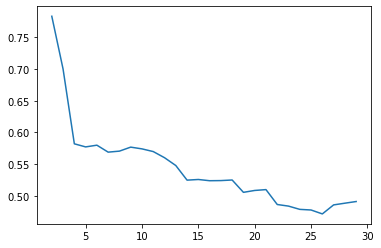

In [14]:
#cluster points
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
cliques_obj = []
num_clusters_obj = []
cluster_sizes_obj = []
for i, (q, t) in enumerate(zip([q_obj], [t_obj])):
    q_regularized = (q - np.mean(q, axis = 0))/np.std(q, axis = 0)
    sil = []
    kmsol = []
    min_k = 2#[5,5, 5]
    max_k = 30#[20, 20, 100 ]
    clus_vals = np.arange(min_k,max_k)
    for k in clus_vals:
        #print(k)
        km = KMeans(n_clusters=k).fit(q_regularized)
        kmsol.append(km)
        labels = km.labels_
        sil.append(silhouette_score(q_regularized, labels, metric='euclidean'))

    fig = plt.figure()
    plt.plot(clus_vals,sil)

    best_clustering = kmsol[np.argmax(sil)]
    num_clusters = clus_vals[np.argmax(sil)]
    q_clus = [q[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    t_clus = [t[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    idx_clus = [np.where(best_clustering.labels_ == l )[0] for l in range(num_clusters)]
    clus_sizes = [len(qc) for qc in q_clus]
    cluster_sizes_obj.append(clus_sizes)
    num_clusters_obj.append(len(q_clus))
    vgraph_clus = [vgraph_handle(qc) for qc in q_clus]
    cliques_cluster = []
    for ad in vgraph_clus:
        smin = 3
        cliques = compute_greedy_clique_partition(ad.toarray(), min_cliuqe_size=smin)
        cl = []
        for c in cliques:
            if len(c)>=smin:
               cl.append(c)
        cliques_cluster.append(cl)
    cliques_clusters_glob = []
    for clus_idx, cliques in enumerate(cliques_cluster):
        for c in cliques:
            if len(c):
                cliques_clusters_glob.append(idx_clus[clus_idx][c])
    cliques_obj.append(cliques_clusters_glob)

In [15]:
#stats on clusters
cliques = 0
clusters = 0
for i in range(len(cluster_sizes_obj)):
    print(f"cliques: {len(cliques_obj[i])}")
    print(f"clusters: { num_clusters_obj[i]}")
    print(f"mean cluster size: {np.mean(cluster_sizes_obj[i])}")
    print(f"mean clique size: {np.mean([len(c) for c in cliques_obj[i]])}")
    print(f"max clique size: {np.max([len(c) for c in cliques_obj[i]])}")
    print(f"min clique size: {np.min([len(c) for c in cliques_obj[i]])}")
    print(f"clique sizes: {[len(c) for c in cliques_obj[i]]}")
    cliques += len(cliques_obj[i])
    clusters += num_clusters_obj[i]

print(f"num cliques: {cliques}")
print(f"num clusters: {clusters}")

cliques: 2
clusters: 2
mean cluster size: 100.0
mean clique size: 100.0
max clique size: 100
min clique size: 100
clique sizes: [100, 100]
num cliques: 2
num clusters: 2


In [16]:
t_tot = t_obj
q_tot = q_obj 
cliques_tot = []
offset = 0
for i, c in enumerate(cliques_obj):
    if i>0:
        offset+= len(q_obj[i-1])
    cliques_tot += [cl + offset for cl in c] 

In [18]:
#direct region generation
ad_tot = vgraph_handle(q_tot)
from clique_covers import (compute_greedy_clique_partition_convex_hull,
                           compute_greedy_clique_cover_w_ellipsoidal_convex_hull_constraint)

cliques_no_clus = compute_greedy_clique_partition(ad_tot.toarray(), min_cliuqe_size=3)
# cliques_no_clus = compute_greedy_clique_cover_w_ellipsoidal_convex_hull_constraint(ad_tot.toarray(), 
#                                                               q_tot,
#                                                               smin = 3,
#                                                               r_scale=1,
                                                              #)

In [18]:
from visibility_utils import get_coverage_estimator, get_sample_cfree_handle, get_col_func
from clique_covers import get_iris_metrics
from region_generation import SNOPT_IRIS_ellipsoid_parallel

q_min = plant.GetPositionLowerLimits()*1
q_max =  plant.GetPositionUpperLimits()*1
col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 1.e-3
termination_threshold = -1
num_collision_infeasible_samples = 100
relative_termination_threshold = 0.02
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 3000)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_snopt_seed_guesses = 200
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold
def col_hnd(pt):
    return 1- 1.0*checker.CheckConfigCollisionFree(pt)

iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = None, 
                        plant_builder = plant_builder,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)

In [19]:
seed_points, metrics, _ = get_iris_metrics([q_tot[c] for c in cliques_tot], col_hnd)
regions_red, succs_sp, is_full = iris_handle(seed_points, metrics, [])

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


In [20]:
seed_points, metrics, _ = get_iris_metrics([q_tot[c] for c in cliques_no_clus], col_hnd)
regions_no_clus, succs_sp, is_full = iris_handle(seed_points, metrics, [])

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


In [21]:
def make_regions_3d(regions):
    regions_3d = []
    for r in regions:
        Aex = np.concatenate((np.zeros((r.A().shape[0],1)),r.A()), axis =1)
        Abox = np.array([[1,0,0],[-1,0,0]])
        bbox = np.array([0.3,0.3])
        Atot = np.concatenate((Aex, Abox), axis=0)
        btot = np.concatenate((r.b(), bbox), axis = 0)
        regions_3d.append(HPolyhedron(Atot, btot))
    return regions_3d


from visualization_utils import plot_regions, generate_maximally_different_colors

colors = generate_maximally_different_colors(len(regions_red)+2)[2:]
plot_regions(meshcat, make_regions_3d(regions_red),region_suffix='/clus/', colors=colors ,offset=_offset_meshcat_2)

colors = generate_maximally_different_colors(len(regions_no_clus)+2)[2:]
plot_regions(meshcat, make_regions_3d(regions_no_clus),region_suffix='/noclus/', colors=colors ,offset=_offset_meshcat_2)
for i, (c, cl) in enumerate(zip(colors, cliques_no_clus)):
    clique = np.concatenate((np.zeros((len(cl),1)),q_tot[cl]), axis =1) + _offset_meshcat_2
    plot_points(meshcat, clique, name = f"cl{i}", size= 0.05, color = Rgba(c[0], c[1], c[2], 0.6))



In [26]:
clique

array([[-1.        , -3.62194481,  2.78062873],
       [-1.        , -3.52404419,  2.82267947],
       [-1.        , -3.49328946,  2.83476462],
       [-1.        , -3.49951323,  2.85458661],
       [-1.        , -3.67376153,  2.68088234],
       [-1.        , -3.54211666,  2.71507875],
       [-1.        , -3.5638019 ,  2.76894443],
       [-1.        , -3.61263576,  2.73881249],
       [-1.        , -3.57568133,  2.75584068]])

In [ ]:

generate_maximally_different_colors(3)